# Multi-class GCN

In [ ]:
!pip install rdkit-pypi

     |████████████████████████████████| 20.6 MB 1.2 MB/s 


In [ ]:
from urllib.request import urlopen
from urllib.parse import quote

def CIRconvert(ids):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(ids) + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return 'Did not work'

identifiers  = ['2-Oxopropanoic acid', 'Pyruvic acid','Pyruvate']

for ids in identifiers :
    print(ids, CIRconvert(ids))

2-Oxopropanoic acid CC(=O)C(O)=O
Pyruvic acid CC(=O)C(O)=O
Pyruvate CC(=O)C([O-])=O


In [ ]:
Chem.MolFromSmiles('CC(=O)C(=O)O')

In [ ]:
from collections import defaultdict
import os
import pickle
import timeit
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from rdkit import Chem
from rdkit.Chem import rdDepictor, Descriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:
# dictionary of atoms where a new element gets a new index
def create_atom_index(mol):
    atoms = [atom_dict[a.GetSymbol()] for a in mol.GetAtoms()]
    atoms = np.array(atoms)
    return atoms

# format from_atomIDx : [to_atomIDx, bondDict]
def create_ijbonddict(mol):
    i_jbond_dict = defaultdict(lambda: [])
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        bond = bond_dict[str(b.GetBondType())]
        i_jbond_dict[i].append((j, bond))
        i_jbond_dict[j].append((i, bond))
    return i_jbond_dict

def create_fingerprints(atoms, i_jbond_dict, radius):
    """Extract the r-radius subgraphs (i.e., fingerprints)
    from a molecular graph using WeisfeilerLehman-like algorithm."""

    if (len(atoms) == 1) or (radius == 0):
        fingerprints = [fingerprint_dict[a] for a in atoms]
    else:
        vertices = atoms
        for _ in range(radius):
            fingerprints = []
            for i, j_bond in i_jbond_dict.items():
                neighbors = [(vertices[j], bond) for j, bond in j_bond]
                fingerprint = (vertices[i], tuple(sorted(neighbors)))
                fingerprints.append(fingerprint_dict[fingerprint])
            vertices = fingerprints

    return np.array(fingerprints)

def create_adjacency(mol):
    adjacency = Chem.GetAdjacencyMatrix(mol)
    n = adjacency.shape[0]
    adjacency = adjacency + np.eye(n)
    degree = sum(adjacency)
    d_half = np.sqrt(np.diag(degree))
    d_half_inv = np.linalg.inv(d_half)
    adjacency = np.matmul(d_half_inv,np.matmul(adjacency,d_half_inv))
    return np.array(adjacency)

def dump_dictionary(dictionary, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(dict(dictionary), f)

def load_pickle(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

Total number of molecules : 6669


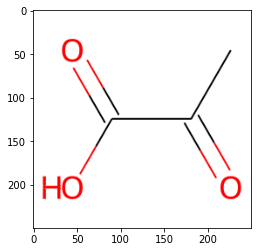

In [ ]:
radius = 2

with open('kegg_classes.txt', 'r') as f:
    data_list = f.read().strip().split('\n')
    
"""Exclude the data contains "." in the smiles, which correspond to non-bonds"""
data_list = list(filter(lambda x: '.' not in x.strip().split()[0], data_list))
N = len(data_list)

print('Total number of molecules : %d' %(N))

atom_dict = defaultdict(lambda: len(atom_dict))
bond_dict = defaultdict(lambda: len(bond_dict))
fingerprint_dict = defaultdict(lambda: len(fingerprint_dict))

Molecules, Adjacencies, Properties, descriptors = [], [], [], []
counts = [0]*11

for no, data in enumerate(data_list):
    smiles, property_indices = data.strip().split('\t')
    property_s = property_indices.strip().split(',')
    
    property = np.zeros((1,11))
    for prop in property_s:
        property[0,int(prop)] = 1
        counts[int(prop)]+=1
        
    Properties.append(property)
    mol = Chem.MolFromSmiles(smiles)

    if no < 1:
        pil_im = Draw.MolToImage(mol, size= (250, 250), kekulize=True, wedgeBonds=True)
        plt.imshow(np.asarray(pil_im))

    atoms = create_atom_index(mol)
    i_jbond_dict = create_ijbonddict(mol)

    fingerprints = create_fingerprints(atoms, i_jbond_dict, radius)
    Molecules.append(fingerprints)
    
    adjacency = create_adjacency(mol)
    Adjacencies.append(adjacency)
    
    desc = np.zeros((7,))
    desc[0] = Descriptors.MolMR(mol)
    desc[1] = Descriptors.MolLogP(mol)
    desc[2] = Descriptors.MolWt(mol)
    desc[3] = Descriptors.NumRotatableBonds(mol)
    desc[4] = Descriptors.NumAliphaticRings(mol)
    desc[5] = Descriptors.NumAromaticRings(mol)
    desc[6] = Descriptors.NumSaturatedRings(mol)
    
    descriptors.append(desc)

dir_input = ('pathway/')
os.makedirs(dir_input, exist_ok=True)
dump_dictionary(atom_dict, dir_input + 'atom_dict.pickle')
dump_dictionary(bond_dict, dir_input + 'bond_dict.pickle')
dump_dictionary(fingerprint_dict, dir_input + 'fingerprint_dict.pickle')

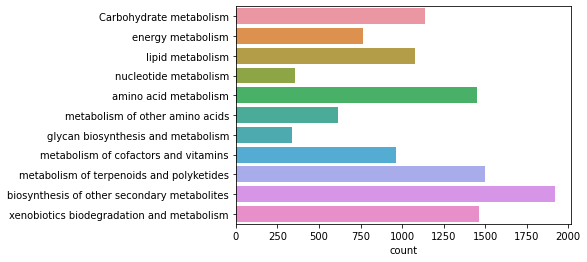

In [ ]:
import seaborn as sns

classes = ["Carbohydrate metabolism", "energy metabolism", "lipid metabolism", "nucleotide metabolism", "amino acid metabolism", "metabolism of other amino acids", "glycan biosynthesis and metabolism", "metabolism of cofactors and vitamins", "metabolism of terpenoids and polyketides", "biosynthesis of other secondary metabolites", "xenobiotics biodegradation and metabolism"]
sns.barplot(x = counts, y = classes)
plt.xlabel("count")
plt.show()

In [ ]:
print(Adjacencies[:1])

[array([[0.5       , 0.35355339, 0.        , 0.        , 0.        ,
        0.        ],
       [0.35355339, 0.25      , 0.35355339, 0.25      , 0.        ,
        0.        ],
       [0.        , 0.35355339, 0.5       , 0.        , 0.        ,
        0.        ],
       [0.        , 0.25      , 0.        , 0.25      , 0.35355339,
        0.35355339],
       [0.        , 0.        , 0.        , 0.35355339, 0.5       ,
        0.        ],
       [0.        , 0.        , 0.        , 0.35355339, 0.        ,
        0.5       ]])]


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
class PathwayPredictor(nn.Module):
    
    def __init__(self):
        super(PathwayPredictor, self).__init__()
        self.embed_atom = nn.Embedding(n_fingerprint, dim)
        self.W_atom = nn.ModuleList([nn.Linear(dim, dim) for _ in range(layer)])
        self.W_property = nn.Linear(dim+extra_dim, 11)
    
    """Pad adjacency matrices for batch processing."""
    def pad(self, matrices, value):
        sizes = [d.shape[0] for d in matrices]
        D = sum(sizes)
        pad_matrices = value + np.zeros((D, D))
        m = 0
        for i, d in enumerate(matrices):
            s_i = sizes[i]
            pad_matrices[m:m+s_i, m:m+s_i] = d
            m += s_i
        return torch.FloatTensor(pad_matrices).to(device)
    
    def sum_axis(self, xs, axis):
        y = list(map(lambda x: torch.sum(x, 0), torch.split(xs, axis)))
        return torch.stack(y)
    
    def update(self, xs, adjacency, i):
        hs = torch.relu(self.W_atom[i](xs))
        return torch.matmul(adjacency, hs)
    
    def forward(self, inputs, sel_desc):
        atoms, adjacency = inputs
        axis = list(map(lambda x: len(x), atoms))
        atoms = torch.cat(atoms)
        x_atoms = self.embed_atom(atoms)
        adjacency = self.pad(adjacency, 0)

        for i in range(layer):
            x_atoms = self.update(x_atoms, adjacency, i)
        
        extra_inputs = sel_desc.to(device)
        y_molecules = self.sum_axis(x_atoms, axis)
        y_molecules = torch.cat((y_molecules,extra_inputs),1)
        z_properties = self.W_property(y_molecules)
        
        return z_properties
    
    def __call__(self, data_batch, train=True):
        sel_desc = torch.FloatTensor(data_batch[-1])
        inputs, t_properties = data_batch[:-2], torch.cat(data_batch[-2])
        z_properties = self.forward(inputs, sel_desc)

        if train:
            loss = F.binary_cross_entropy(torch.sigmoid(z_properties), t_properties)
            return loss
        else:
            zs = torch.sigmoid(z_properties).to('cpu').data.numpy()
            ts = t_properties.to('cpu').data.numpy()
            scores = list(map(lambda x: x, zs))
            labels = list(map(lambda x: (x>=0.5).astype(int), zs))
            return scores, labels, ts

In [ ]:
class Trainer(object):
    def __init__(self, model):
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        
    def train(self, dataset_train):
        N = len(dataset_train)
        loss_total = 0
        for i in range(0, N, batch):
            data_batch = list(zip(*dataset_train[i:i+batch]))
            loss = self.model(data_batch)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_total += loss.to('cpu').data.numpy()
        return loss_total

class Tester(object):
    def __init__(self, model):
        self.model = model

    def test(self, dataset_test):
        N = len(dataset_test)
        score_list, label_list, t_list = [], [], []

        for i in range(0, N, batch):
            data_batch = list(zip(*dataset_test[i:i+batch]))
            scores, labels, ts = self.model(data_batch, train=False)
            score_list = np.append(score_list, scores)
            label_list = np.append(label_list, labels)
            t_list = np.append(t_list, ts)
        
        auc = accuracy_score(t_list, label_list)
        precision = precision_score(t_list, label_list)
        recall = recall_score(t_list, label_list)
        
        return auc, precision, recall

In [ ]:
dim = 70
extra_dim = 7
layer = 2
batch = 10
lr = 1e-3
lr_decay = 0.50
decay_interval = 20
iteration = 50

Molecules = [torch.LongTensor(d).to(device) for d in Molecules]
t_properties = [torch.FloatTensor(d).to(device) for d in Properties]
descriptors = np.array(descriptors)

dataset = list(zip(Molecules, Adjacencies, t_properties, descriptors))

from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(dataset, test_size=0.1)

n_fingerprint = len(fingerprint_dict)

In [ ]:
torch.manual_seed(123)

model = PathwayPredictor().to(device)
trainer = Trainer(model)
tester = Tester(model)

print('Training...')
print('Epoch \t Time(sec) \t Loss_train \t AUC_test \t Precision \t Recall')

start = timeit.default_timer()
Loss = []
Auc_Test = []
Precision = []
Recall =[]
for epoch in range(iteration):
    if (epoch+1) % decay_interval == 0:
        trainer.optimizer.param_groups[0]['lr'] *= lr_decay

    loss = trainer.train(dataset_train)
    Loss.append(loss)
    auc_test, precision, recall = tester.test(dataset_test)
    Auc_Test.append(auc_test)
    Precision.append(precision)
    Recall.append(recall)

    lr_rate = trainer.optimizer.param_groups[0]['lr']

    end  = timeit.default_timer()
    time = end - start

    print('%d \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f' %(epoch+1, time, loss, auc_test, precision, recall))

Training...
Epoch 	 Time(sec) 	 Loss_train 	 AUC_test 	 Precision 	 Recall


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


1 	 4.1342 	 560.5357 	 0.8915 	 0.6689 	 0.5446
2 	 9.4865 	 146.9324 	 0.9109 	 0.7256 	 0.6503
3 	 15.8662 	 120.8863 	 0.9214 	 0.7522 	 0.7077
4 	 23.2976 	 102.3434 	 0.9309 	 0.7744 	 0.7596
5 	 28.3248 	 88.6333 	 0.9349 	 0.7778 	 0.7905
6 	 31.7434 	 77.3113 	 0.9402 	 0.7903 	 0.8169
7 	 35.1162 	 68.6262 	 0.9436 	 0.7923 	 0.8443
8 	 38.4770 	 61.0964 	 0.9453 	 0.7936 	 0.8579
9 	 41.7874 	 54.7912 	 0.9482 	 0.7997 	 0.8725
10 	 45.0939 	 49.5898 	 0.9508 	 0.8089 	 0.8789
11 	 48.3891 	 45.1833 	 0.9546 	 0.8201 	 0.8925
12 	 51.7594 	 41.8056 	 0.9567 	 0.8294 	 0.8944
13 	 55.1757 	 39.1522 	 0.9583 	 0.8379 	 0.8944
14 	 58.4709 	 36.4231 	 0.9592 	 0.8441 	 0.8925
15 	 61.7998 	 34.6316 	 0.9613 	 0.8533 	 0.8953
16 	 65.1123 	 33.1086 	 0.9618 	 0.8619 	 0.8871
17 	 68.4498 	 31.6669 	 0.9620 	 0.8634 	 0.8862
18 	 71.7651 	 30.6272 	 0.9643 	 0.8725 	 0.8916
19 	 75.0856 	 29.4705 	 0.9632 	 0.8677 	 0.8898
20 	 78.4829 	 23.9668 	 0.9667 	 0.8847 	 0.8944
21 	 82

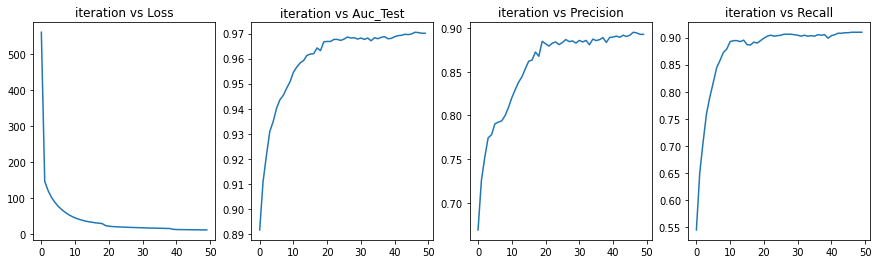

In [ ]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 4, 1)
plt.plot(range(iteration), Loss)
plt.title("iteration vs Loss")

plt.subplot(1, 4, 2)
plt.plot(range(iteration), Auc_Test)
plt.title("iteration vs Auc_Test")

plt.subplot(1, 4, 3)
plt.plot(range(iteration), Precision)
plt.title("iteration vs Precision")

plt.subplot(1, 4, 4)
plt.plot(range(iteration), Recall)
plt.title("iteration vs Recall")

plt.show()

In [ ]:
data_batch = list(zip(*dataset_test[:]))

sel_desc = torch.FloatTensor(data_batch[-1])    
inputs, t_properties = data_batch[:-2], torch.cat(data_batch[-2])
z_properties = model.forward(inputs, sel_desc)

torch.set_printoptions(precision=2)
p_properties = torch.sigmoid(z_properties)

p_properties = p_properties.data.to('cpu').numpy()
t_properties = t_properties.data.to('cpu').numpy()

p_properties[p_properties<0.5]  = 0
p_properties[p_properties>=0.5] = 1

Auc = []
Precision = []
Recall = []

for c in range(11):
    y_true = t_properties[:,c]
    y_pred = p_properties[:,c]
    
    auc = accuracy_score(y_true, y_pred)
    Auc.append(auc)
    precision = precision_score(y_true, y_pred)
    Precision.append(precision)
    recall = recall_score(y_true, y_pred)
    Recall.append(recall)
    print('Class '+str(c+1)+' statistics:')
    print('Accuracy %.4f, Precision %.4f, Recall %.4f\n' %(auc, precision, recall))

Class 1 statistics:
Accuracy 0.9790, Precision 0.9280, Recall 0.9587

Class 2 statistics:
Accuracy 0.9835, Precision 0.8800, Recall 0.9706

Class 3 statistics:
Accuracy 0.9805, Precision 0.9065, Recall 0.9700

Class 4 statistics:
Accuracy 0.9910, Precision 0.8286, Recall 1.0000

Class 5 statistics:
Accuracy 0.9415, Precision 0.8792, Recall 0.8618

Class 6 statistics:
Accuracy 0.9820, Precision 0.8871, Recall 0.9167

Class 7 statistics:
Accuracy 0.9910, Precision 0.9355, Recall 0.8788

Class 8 statistics:
Accuracy 0.9595, Precision 0.9167, Recall 0.7586

Class 9 statistics:
Accuracy 0.9580, Precision 0.8433, Recall 0.9417

Class 10 statistics:
Accuracy 0.9445, Precision 0.8848, Recall 0.9185

Class 11 statistics:
Accuracy 0.9610, Precision 0.9275, Recall 0.8889



In [ ]:
torch.save(model.state_dict(), "gnc.pth")

In [ ]:
model = PathwayPredictor().to(device)
model.load_state_dict(torch.load("gnc.pth"))
model.eval()

PathwayPredictor(
  (embed_atom): Embedding(4382, 70)
  (W_atom): ModuleList(
    (0): Linear(in_features=70, out_features=70, bias=True)
    (1): Linear(in_features=70, out_features=70, bias=True)
  )
  (W_property): Linear(in_features=77, out_features=11, bias=True)
)

#Multi-class Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:
my_desc = []
for i in range(len(Molecules)):
    target_mol = (n_fingerprint-1)*torch.ones([259], dtype=torch.float, device=device)
    target_mol[:Molecules[i].size()[0]] = Molecules[i]
    my_desc.append(np.concatenate((target_mol.cpu().data.numpy(), descriptors[i]), axis=0))

dataset = list(zip(t_properties, my_desc))

from sklearn.model_selection import train_test_split
dataset_train, dataset_test = train_test_split(dataset, test_size=0.1)

data_batch = list(zip(*dataset_train))
properties_train, desc_train = data_batch[-2], data_batch[-1]

data_batch = list(zip(*dataset_test))
properties_test, desc_test = data_batch[-2], data_batch[-1]

train_len, test_len = len(dataset_train), len(dataset_test)

feature_len = desc_train[0].shape[0]

X_train, X_test = np.zeros((train_len,feature_len)), np.zeros((test_len,feature_len))
Y_train, Y_test = np.zeros((train_len,11)), np.zeros((test_len,11))

for i in range(train_len):
    X_train[i,:] = desc_train[i]
    Y_train[i] = properties_train[i][0]
    
for i in range(test_len):
    X_test[i,:]  = desc_test[i]
    Y_test[i]  = properties_test[i][0]

In [ ]:
clf = RandomForestClassifier(n_estimators=300, criterion = 'gini', max_depth=60, random_state=None)
multi_target_forest = MultiOutputClassifier(clf)
multi_target_forest.fit(X_train, Y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=60,
                                                       n_estimators=300))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Y_pred = multi_target_forest.predict(X_test)

acc_score, prec_score, rec_score = 0., 0., 0.
Accuracy_RF = []
Precision_RF = []
Recall_RF = []
for i in range(Y_test.shape[0]):
    acc_score  += accuracy_score(Y_test[i],Y_pred[i])
    Accuracy_RF.append(acc_score)
    prec_score += precision_score(Y_test[i],Y_pred[i])
    Precision_RF.append(prec_score)
    rec_score  += recall_score(Y_test[i],Y_pred[i])
    Recall_RF.append(rec_score)

acc_score  = acc_score/Y_test.shape[0]
prec_score = prec_score/Y_test.shape[0]
rec_score  = rec_score/Y_test.shape[0]

print('Accuracy : %.4f%%, \t Precision : %.4f%%, \t, Recall : %.4f%%' %(acc_score, prec_score, rec_score))

Accuracy : 0.9731%, 	 Precision : 0.8076%, 	, Recall : 0.8115%


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=10)
multi_target_lr = MultiOutputClassifier(clf)
multi_target_lr.fit(X_train, Y_train)

MultiOutputClassifier(estimator=LogisticRegression(random_state=10))

In [ ]:
Y_pred = multi_target_lr.predict(X_test)

acc_score, prec_score, rec_score = 0., 0., 0.
Accuracy_lr = []
Precision_lr = []
Recall_lr = []
for i in range(Y_test.shape[0]):
    acc_score += accuracy_score(Y_test[i],Y_pred[i])
    Accuracy_lr.append(acc_score)
    prec_score += precision_score(Y_test[i],Y_pred[i])
    Precision_lr.append(prec_score)
    rec_score += recall_score(Y_test[i],Y_pred[i])
    Recall_lr.append(rec_score)

acc_score = acc_score/Y_test.shape[0]
prec_score = prec_score/Y_test.shape[0]
rec_score = rec_score/Y_test.shape[0]

print('Accuracy : %.4f%%, \t Precision : %.4f%%, \t, Recall : %.4f%%' %(acc_score, prec_score, rec_score))

Accuracy : 0.8539%, 	 Precision : 0.2364%, 	, Recall : 0.1853%


#K-Neighbors Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=12)
multi_target_knn = MultiOutputClassifier(clf)
multi_target_knn.fit(X_train, Y_train)

MultiOutputClassifier(estimator=KNeighborsClassifier(n_neighbors=12))

In [ ]:
Y_pred = multi_target_knn.predict(X_test)

acc_score, prec_score, rec_score = 0., 0., 0.
Accuracy_knn = []
Precision_knn = []
Recall_knn = []
for i in range(Y_test.shape[0]):
    acc_score += accuracy_score(Y_test[i],Y_pred[i])
    Accuracy_knn.append(acc_score)
    prec_score += precision_score(Y_test[i],Y_pred[i])
    Precision_knn.append(prec_score)
    rec_score += recall_score(Y_test[i],Y_pred[i])
    Recall_knn.append(rec_score)

acc_score = acc_score/Y_test.shape[0]
prec_score = prec_score/Y_test.shape[0]
rec_score = rec_score/Y_test.shape[0]

print('Accuracy : %.4f%%, \t Precision : %.4f%%, \t, Recall : %.4f%%' %(acc_score, prec_score, rec_score))

Accuracy : 0.8866%, 	 Precision : 0.4267%, 	, Recall : 0.4200%
